In [1]:
from fcsy import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
import FlowCal
import scipy.optimize as scio
from scipy.stats import poisson
import seaborn as sns
import colorsys
import itertools
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Circle
import scipy.stats as st
from mpl_toolkits import mplot3d

# Functions

In [2]:
# Function to read in fcs file and drop unnecessary columns and rename channels to FLx

def restructure(data):
    #data = DataFrame.from_fcs(fcs_file)
    
    data = data.drop(['TIME','FSC-A','FSC-H','FSC-W','SSC-A'],axis=1)

    data.columns = ['FL1','FL2','FL3','FL4','FL5']
    
    return data

In [3]:
def calibration(exp,beads):
    s_transformed = FlowCal.transform.to_rfi(beads)
    
    # Channel 1 calibration
    MEFL_values = np.array([0,771,2106,6262,15183,45292,136258,291042])

    # Channel 2 calibration
    MEPE_values = np.array([0,487,1474,4516,11260,34341,107608,260461])

    # Channel 3 calibration
    MECY_values = np.array([0,1414,3809,10852,27904,85866,324106,1040895])
    
    # Channel 4 + 5 calibration
    MEAP_values = np.array([0,341,1027,3156,7750,23446,68702,116813])
    
    
    # functions to calibrate to proper units
    channel_1 = FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEFL_values,
                                        mef_channels='FL1',
                                        plot=False)
    
    
    channel_2 = FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEFL_values,
                                        mef_channels='FL2',
                                        plot=False)

    
    channel_3 =  FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MECY_values,
                                        mef_channels='FL3',
                                        plot=False)
    
    channel_4 =  FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEAP_values,
                                        mef_channels='FL4',
                                        plot=False)
    
    channel_5 =  FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEAP_values,
                                        mef_channels='FL5',
                                        plot=False)
   

    ####### Functions to get bead model data ##### - write as dictionary 
    ch1_out = FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEFL_values,
                                        mef_channels='FL1',
                                        plot=False,full_output=True)
    
    
    ch2_out = FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEFL_values,
                                        mef_channels='FL2',
                                        plot=False,full_output=True)

    
    ch3_out =  FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MECY_values,
                                        mef_channels='FL3',
                                        plot=False,full_output=True)
    
    ch4_out =  FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEAP_values,
                                        mef_channels='FL4',
                                        plot=False,full_output=True)
    
    ch5_out =  FlowCal.mef.get_transform_fxn(s_transformed,
                                        mef_values=MEAP_values,
                                        mef_channels='FL5',
                                        plot=False,full_output=True)
    
    
    cal_fxn_dictionary = {0:list(ch1_out[5]['beads_params'][0][:2]),1:list(ch2_out[5]['beads_params'][0][:2]),
                         2:list(ch3_out[5]['beads_params'][0][:2]),3:list(ch4_out[5]['beads_params'][0][:2]),
                         4:list(ch5_out[5]['beads_params'][0][:2])}
    
   
    # Apply functions to data
    transformed_experiment = FlowCal.transform.to_rfi(exp)
    
    # Transform experiment
    FL1_corrected = channel_1(transformed_experiment,channels='FL1')
    FL2_corrected = channel_2(transformed_experiment,channels='FL2')
    FL3_corrected = channel_3(transformed_experiment,channels='FL3')
    FL4_corrected = channel_4(transformed_experiment,channels='FL4')
    FL5_corrected = channel_5(transformed_experiment,channels='FL5')
    
    
    channels = ['FL1','FL2','FL3','FL4','FL5']
    
    # Pull all of the right calibrated values for each channel
    FL1_list = list(FL1_corrected[:,0])
    FL2_list = list(FL2_corrected[:,1])
    FL3_list = list(FL3_corrected[:,2])
    FL4_list = list(FL4_corrected[:,3])
    FL5_list = list(FL5_corrected[:,4])
        
        
    
    # List of lists to tie together into a new dictionary
    data = [FL1_list,FL2_list,FL3_list,FL4_list,FL5_list]

    
    # Make the dictionary so we can turn it into a dataframe
    dictionary_data = dict(zip(channels,data))
    
    calibrated_dataframe = pd.DataFrame(dictionary_data)
    
    
    
    # Return the calibrated data
    return calibrated_dataframe, cal_fxn_dictionary

In [4]:
def normalize(control,experiment):
    
    # remove autofluorescence signal for each channel
    for i in control.columns:
        af_list = list(control[i])
        af_list.sort()
        
        # AF is anything but the top 5% of values in the control 
        cutoff = int(len(af_list) - 0.05*len(af_list))
        
        # This is the autofluorescence value to remove from our experiment in the given channel
        af_value = af_list[cutoff]
       
       
        # Subtract the autofluorescence in our experiment
        experiment[i] = experiment[i]-af_value
        
    
    
   #### USE THIS AS NEW FUSION PROTEIN CORRECTION STUFF
    #### Check if any of our channels are above 0 after AF correction
    #### If they are, then keep it. If not, that cell must not have had any protein expressed
    keys = list(experiment.columns)
    values = [[],[],[],[],[]]

    for i in experiment.values:
        if any(j>0 for j in i):    #uncomment this line when you have biliverdin and fluorescence from miRFP!
            values[0].append(i[0])
            values[1].append(i[1])
            values[2].append(i[2])
            values[3].append(i[3])
            values[4].append(i[4])
        
    answer = pd.DataFrame(dict(zip(keys,values)))

        
    return answer

In [5]:
def prep(normed_dataframe,max_vector):

    # Get rid of channels 4 and 5 for color analysis - should put in some control here where I drop cells that have 0 across
    # the board - maybe will do that in normalize function
    three_vec = normed_dataframe.drop(['FL4','FL5'],axis=1)
    three_vec_values = three_vec.values

    # Once fusion is gone, change negative values to just be 0 in the vector
    three_vec_values = np.where(three_vec_values<0,0,three_vec_values)

    # normalize each channel in the vector to be 0-1, with 1 being the channel with the highest signal. This is crucial for 
    # the next binning step
    for i, vec in enumerate(three_vec_values):
        three_vec_values[i] = vec/max(max_vector) 

    # Some cells were all below autofluorescence and so had 0's in every channel. max=0 means divide by 0 = NaN
    # this line will convert nans to 0s
    three_vec_values = np.nan_to_num(three_vec_values,nan=0,neginf=0)
    
    # After dividing by mean and stdev, make things higher at 1
    three_vec_values = np.where(three_vec_values > 1,1,three_vec_values) 

    # make a list dictating all of the bin intervals and make a list to hold the vectors for each bin
    #bin_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    bin_list = list(np.arange(0,1.025,0.025))
    bin_vec_list = []

    
    # HSV conversion. Specific to this version of the code. Previous version uses RGB. Note that THIS causes
    # some differences in the final neighborhood graph because you do this step, which alters the bins,
    # prior to doing any of the linear modeling, based on the bins
    for i, vec in enumerate(three_vec_values):
        three_vec_values[i] = colorsys.rgb_to_hsv(vec[2],vec[1],vec[0])     
    
    # for each of the 3 channels 
    for i in range(3):
        #bin_vector = []
        fig, ax = plt.subplots()
        
        # make a histogram of each of the channels (i = 1 = all channel 1 values, i = 2 = all channel 2 vals ...)
        n,bins,patches = ax.hist(three_vec_values[:,i],bins=bin_list)
    
        ax.set_title('channel ' + str(i+1))

        bin_index = np.digitize(three_vec_values[:,i],bins,right=True)
      
        bin_vec_list.append(list(bin_index))
        
    vecs = []
    
    for i, v in enumerate(list(range(0,len(three_vec['FL1'])))):
        vecs.append(tuple([bin_vec_list[0][i]/4,bin_vec_list[1][i]/4,bin_vec_list[2][i]/4]))
        
    # Assign the channel bins to each cell
    three_vec['bin vector'] = vecs
    
    # This yields a dictionary of how many times we saw each bin [0,0,0],[0,0,.1],[0,0,.2]....
    val_counts = dict(three_vec['bin vector'].value_counts())
    
    sum_counts = sum(val_counts.values())

    new_val_counts = {key:val/sum_counts for key, val in val_counts.items()}
    
    return val_counts

In [6]:
def lin_mix_model(bin_counts,avg_lambda,lambdas,result_dict):
    # Get the thetas from a poisson distribution (for now) given the avg mutation rate and expected for 
    # each mutation rate (in this case 8 for 8 libraries) - the highest one
    thetas = [poisson.pmf(l,avg_lambda) for l in lambdas[:-1]]
    
    # This last theta represents the highest mutation rate plus anything higher than (e.g. 8 if 8 is the highest mutation rate)
    thetas.append(1-sum(thetas))
    
    
    # mutation rate fractions to optimize (e.g. g1, g2, g3 ....g8)
    params = [0.001]*len(lambdas)
    
    # Write objective function to optimize predicted mutation fractions
    def objective(params,muts,obs):
        pred = sum([params[index]*val for index,val in enumerate(muts)])
        
        return pred-obs
    
        
    # Least squares function gives the inferred g0,g1,g2... with x.x
    ope = 0
    for bin_key, counts in bin_counts.items():
        x = scio.least_squares(objective,params,bounds=(0,np.inf),args=[thetas,counts])
    
        
        for ind,val in enumerate(x.x):
            result_dict[bin_key][ind] += (val*thetas[ind])

    return result_dict


In [7]:
def prep_neighborhood_dict(result_dictionary):
    
    # Create all the bins for the intervals in the three channels [0,0,0],[0,0,1],[0,0,2]....[10,10,10]
    x = list(np.arange(0,10.25,0.25))
    xnew = []
    for i in x:
        xnew.append(np.round(i,2))
    all_bins = [p for p in itertools.product(xnew,repeat=3)]

    # for every bin, give it a blank dictionary to hold the cells
    for i in all_bins:
        result_dictionary[i] = {}
    
    # For each bin and it's empty dictionary, give it a mutation rate key (THIS COULD CHANGE WITH NGS DATA) and set its value to 0
    # Basically, for each bin vector, how many cells with a given number of mutations fit that bin vector?
    for bins, val in result_dictionary.items():
        for i in range(0,7,1):
            val[i] = 0
        

    
    return result_dictionary

In [8]:
### Normalize the data to the center ring just being green or red or orange or whatever

def norm_ring_data(res,base_color):
    
    total_list = []
    for i in range(7):  #The range here is set based on how many rings I'm making
        tot = 0
        for value in res.values():
            tot += value[i]
        total_list.append(tot)
    
    # Change the list(k)[0] is hue cutoffs here for normalization. list(k)[1] is saturation and list(k)[2] is value
    dead = (0,0,0)

            
    reduction_percent = res[dead][0]/total_list[0]
    
    
    for step, number in res[dead].items():
        reduction = number-(reduction_percent*total_list[step])
        if reduction > 0:
            res[dead][step] = reduction
        else:
            res[dead][step] = 0
    

    
                    
    # Just keep the bins that actually have cells recorded in them
    trimmed_dict = {key:value for key, value in res.items() if sum(value.values()) >0}
    
    return trimmed_dict,res

In [9]:
def make_ring2(neighborhood_dict,step,radius,hue_amplifier=2,brightness_amplifier=3):
    total = 0
    for key, value in neighborhood_dict.items():
        total += value[step]
        
    cols = []
    fracs = []
    brightness = []
    

    differences = []
    hsv_keys = []

    full_green = colorsys.rgb_to_hsv(1,0,0)
    #green_ref = sum(full_green)
    green_ref = (0,1,1)
  
    for j in neighborhood_dict.keys():
        hsv_calc = np.array(j)/10
        difference = []
        for i,v in enumerate(list(green_ref)):
            if i == 0:
                difference.append((1+abs(v-hsv_calc[i]))**hue_amplifier)
            elif i ==2:
                difference.append((1+abs(v-hsv_calc[i]))**brightness_amplifier)
            
            
        differences.append(sum(difference))
        hsv_keys.append(tuple(np.array(j)/10))


    differences, hsv_keys = zip(*sorted(zip(differences,hsv_keys),reverse=True))
    
    for hsv in hsv_keys:
        brightness.append(hsv[2])
    
    
    
    for color in hsv_keys:
        original = tuple(np.array(color)*10)
        bins = neighborhood_dict[original]
        
        frac = bins[step]/total
        
        fracs.append(frac)
        #fracs2.append(frac)
    

    final_hsv = []
    final_fracs = []
  
    dead_frac = 0

    for i,v in enumerate(hsv_keys):
        if colorsys.hsv_to_rgb(v[0],v[1],1) == (1,1,1):
            dead_frac += (fracs[i])
        else:
            final_hsv.append(v)
            final_fracs.append(fracs[i])

    final_hsv.insert(0,'gray')
    final_fracs.insert(0,dead_frac)

    return [final_hsv,final_fracs],[brightness,final_fracs]    # cols and fracs are hues, new_cols and fracs 2 is brightness



In [10]:
def brightness_analysis(normed_ring_data,save=False,filepath='library_patterns/brightness_data.pdf'):
    #violin plot brightness distribution
    hue_list = [[],[],[],[],[],[],[]]
    for hsv, rings in normed_ring_data.items():
        if hsv != (0,0,0):                               # only things that have color (i.e. not dead)
            for ring,num in rings.items():
                to_add = np.array([hsv[2]] * int(np.round(num,0)))/10
                if len(to_add) > 1:
                    for i in to_add:
                        hue_list[ring].append(i)

    
    # bar chart percent of brightness
    brightnesses = [np.mean(v) for v in hue_list]
    medians = [np.mean(v) for v in hue_list]

    zero_ring = max(brightnesses)


    xpos = [0,1,2,3,4,5,6]
    ypos = []
    facecolors = []
    confidence_intervals = []
    
    for i in hue_list:
        ypos.append(np.mean(i)) #/zero_ring))
        facecolors.append((np.mean(i)/0.408))   # max brightness is 0.41 ish
        i.sort()
        total_obs = len(i)
        lower_idx = int(0.025*total_obs)
        upper_idx = int(0.975*total_obs)
        
        upper_interval = i[upper_idx]
        lower_interval = i[lower_idx]
        confidence_intervals.append([lower_interval,upper_interval])

    #fig, ax = plt.subplots(figsize=(12,5))
    
    #for i,ring in enumerate(hue_list):
     #   if i == 0:
      #      sns.kdeplot(ring,ax=ax,color='black',alpha=0.04,label=f'{i}',shade=True)
      #  else:
       #     sns.kdeplot(ring,ax=ax,color='black',alpha=i/len(hue_list),label=f'{i}')
            
   # ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.legend(loc='best',ncol=len(hue_list),title='# mutations')
    
    #ax.set_xlabel('Brightness value',fontsize=14)
    #ax.set_ylabel('Frequency',fontsize=14)

    
    # plot things
    fig,ax = plt.subplots(1,1,figsize=(8,5))


    #sns.violinplot(data=hue_list,palette="viridis_r",as_cmap=True,ax=ax[0])
    sns.violinplot(data=hue_list,ax=ax,color='lightgray',inner='box')
    #(GFP)
    #ax.plot(list(range(len(medians))),[0.3956145568880722,0.32577417647837015,0.36270471581743996,0.393564124720962,0.4047027844405047,0.40296811302842456,0.38940744003252475],'--',color=(0.0,1.0,0.6),linewidth=3.5,label='AncGFP')
    #(Anc15)
    #ax.plot(list(range(len(medians))),[0.25789674497735743,0.137337913715563,0.1259182888471239,0.10996928218366654,0.09684191355026711,0.08890809564966869,0.08539810690423162],'--',color=(1,0,0.6),linewidth=3.5,label='Anc15')

    ax.plot(list(range(len(medians))),medians,'-',color='black',linewidth=4)
    ax.scatter(list(range(len(medians))),medians,facecolor='white',edgecolor='black',s=80,zorder=100,linewidth=2)
    
    loc = 1/7
    for i in list(range(len(medians))):
        ax.axhline(xmin=loc-0.1,xmax=loc-0.01,y=confidence_intervals[i][0],color='blue',linewidth=2)
        ax.axhline(xmin=loc-0.1,xmax=loc-0.01,y=confidence_intervals[i][1],color='blue',linewidth=2)
        loc += 1/7.1
    sns.set_theme(context='notebook', style='ticks')
    
    #sns.violinplot(data=hue_list,width=0.9,linewidth=2,palette='Blues',ax=ax[0])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['0','1','2','3','4','5','6+'])
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)
    ax.set_ylabel('Brightness distribution',fontsize=16)
    ax.set_xlabel('Mutation ring number',fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(0,1.05)


    
    
    
    
    
    
    #ax[1].bar(xpos,height=ypos,color=[str(x) for x in facecolors],edgecolor='black')
    #ax[1].scatter(xpos,ypos,color=[str(x) for x in facecolors],edgecolor='black',s=85,zorder=2)
    #ax[1].plot(xpos,ypos,color='black',zorder=1)
    #ax[1].set_xticks([0,1,2,3,4,5,6])
    #ax[1].set_xticklabels(['0','1','2','3','4','5','6+'])
    #ax[1].tick_params(axis='x',labelsize=14)
    #ax[1].tick_params(axis='y',labelsize=14)
    #ax[1].set_ylim(0,0.405)
    #ax[1].set_ylabel('Avg brightness',fontsize=16)
    #ax[1].set_xlabel('Mutation ring number',fontsize=16)
    #ax[1].spines['right'].set_visible(False)
    #ax[1].spines['top'].set_visible(False)
    
    if save:
        plt.savefig(filepath)
    return hue_list,facecolors,medians


# Analysis

In [11]:
# Bead calibration file and control data
correct_beads = FlowCal.io.FCSData("calibration_beads_corrected.fcs")
actual_control = FlowCal.io.FCSData("Negative_control_corrected.fcs")

# params for lin mix model and things
mutation_rates = list(range(7))
library_mutation_rates = {0:0,1000:1.06,750:1.29,500:1.55,250:1.4,100:2.04,50:2.7,10:3.14,1:3.42}

In [12]:
s_sub_ch = correct_beads[:,:]
s_sub_ch2 = actual_control[:,:]

control,out = calibration(s_sub_ch2,s_sub_ch)

# Grab mean and stdev of brightness to normalize all the libraries

In [13]:
prelim = {}
stackdata = {}
res = prep_neighborhood_dict(prelim)
    
hist_dat = {0:[],1:[],10:[],50:[],100:[],250:[],500:[],750:[],1000:[]}

vector_choices = []
dfs_to_plot = []

for file in glob.iglob('Library_files/*_corrected.fcs'):
    f = str(file).split('_')
    
    pattern = re.compile('\d+')

        # Library number
    match  = re.search(pattern,f[1])
    
    
    library = int(match.group())
    
        # associated mutation rate with library number
    mut_rate = library_mutation_rates[library]
    
        # Read in data as flowcal file
    expe = FlowCal.io.FCSData(file)
    
    
    s_sub_expe = expe[:,:]
    
        # Calibrate data using calibration beads
    calibrated_thing,eqs = calibration(s_sub_expe,correct_beads)
    
    
    # Subtract out fusion protein and remove autofluorescence
    normed_thing = normalize(control,calibrated_thing)
    #normed_thing2 = normed_thing[normed_thing >0]
    #normed_thing2 = np.log10(normed_thing2)
    #normed_thing2 = normed_thing2.fillna(value=0)
    #dfs_to_plot.append(normed_thing2)
    
    three_vec = normed_thing.drop(['FL4','FL5'],axis=1)
    three_vec_values = three_vec.values

    # Once fusion is gone, change negative values to just be 0 in the vector
    three_vec_values = np.where(three_vec_values<0,0,three_vec_values)
    vector_choices.append(three_vec_values[::-1])
    
    
means = np.mean(vector_choices[0],axis=0)
st2 = 2*(np.std(vector_choices[0],axis=0))
max_vector = means+st2
final_max_vector = [max(max_vector),max(max_vector),max(max_vector)]

    

# Use above vector data to normalize the space and measure neighborhood

done with 0 library
done with 1000 library
done with 100 library
done with 10 library
done with 1 library
done with 250 library


C:\Users\micha\AppData\Local\Temp\ipykernel_28588\3809653053.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


done with 500 library
done with 50 library
done with 750 library


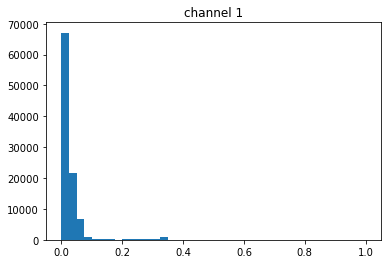

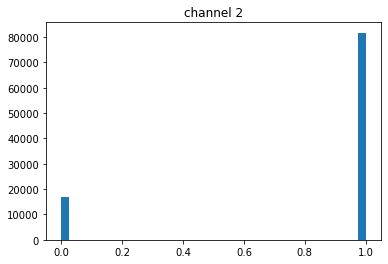

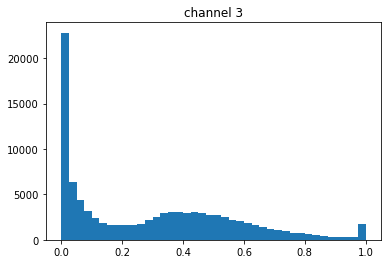

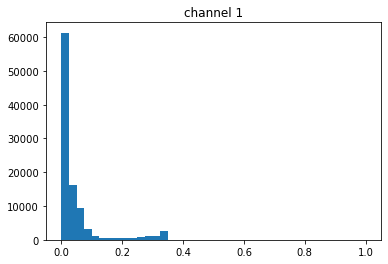

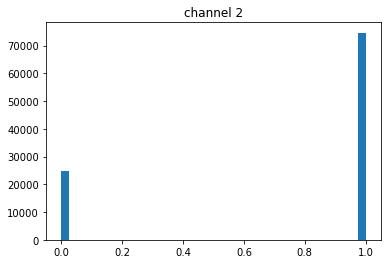

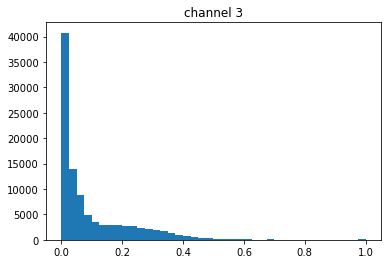

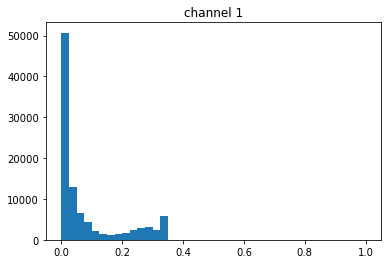

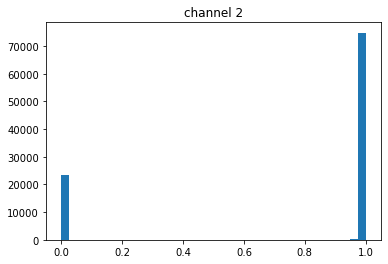

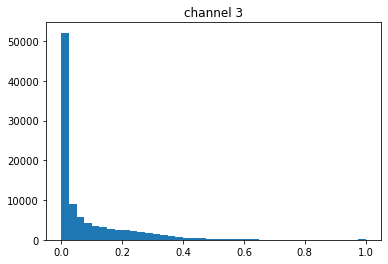

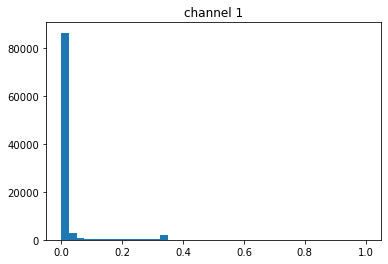

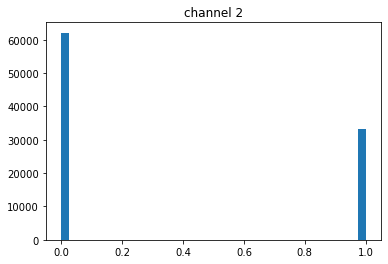

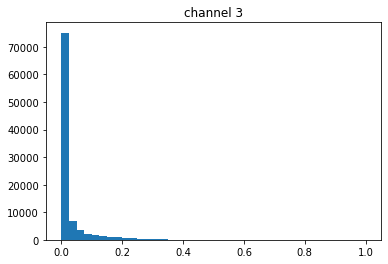

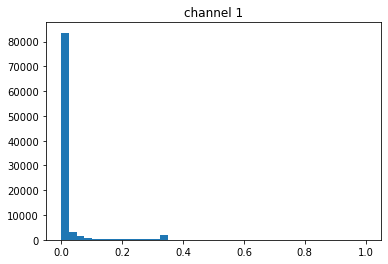

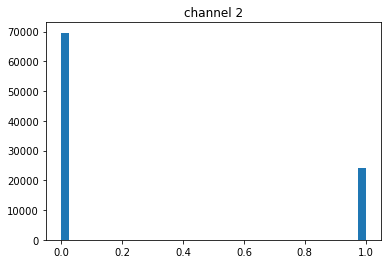

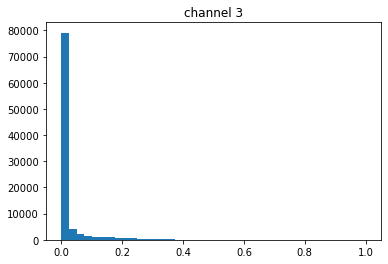

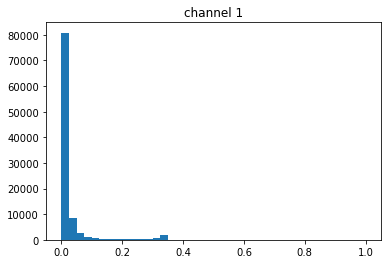

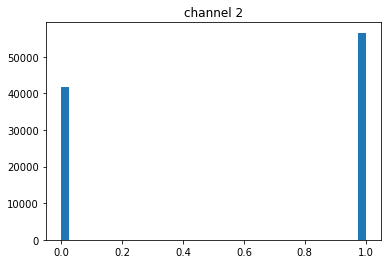

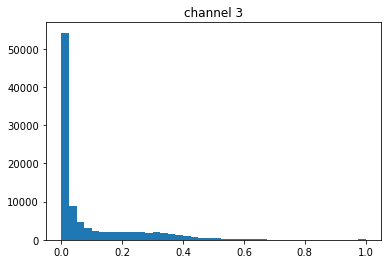

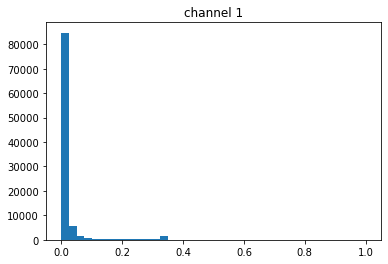

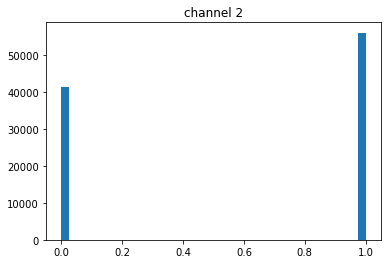

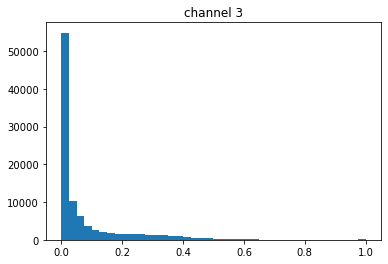

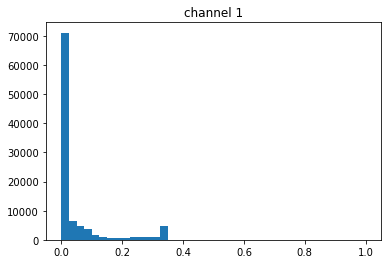

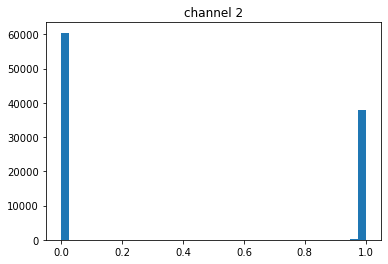

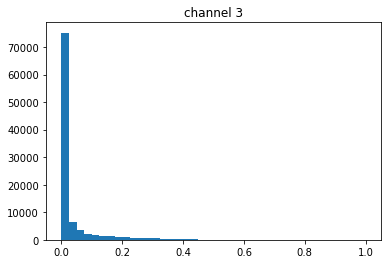

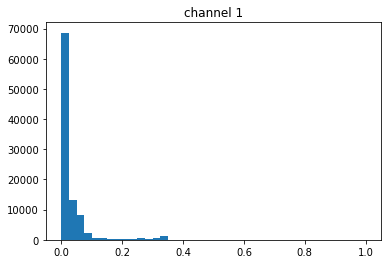

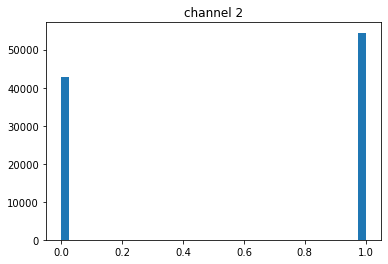

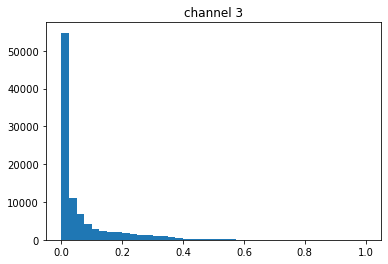

In [14]:
prelim = {}
stackdata = {}
res = prep_neighborhood_dict(prelim)
brightnesses = []
for file in glob.iglob('Library_files/*_corrected.fcs'):
    f = str(file).split('_')
    pattern = re.compile('\d+')
    
        # Library number
    match  = re.search(pattern,f[1])
    
    
    library = int(match.group())
    
        # associated mutation rate with library number
    mut_rate = library_mutation_rates[library]
    
        # Read in data as flowcal file
    expe = FlowCal.io.FCSData(file)
    s_sub_expe = expe[:, :]
    
        # Calibrate data using calibration beads
    calibrated_thing,eqs = calibration(s_sub_expe,correct_beads)
    
        # Subtract out fusion protein and remove autofluorescence
    normed_thing = normalize(control,calibrated_thing)
    
        # 
    prepped = prep(normed_thing,final_max_vector)
    #brightnesses.append(brights)
    
    result = lin_mix_model(prepped,mut_rate,mutation_rates,res)

    normed_rings,old_result = norm_ring_data(result,'green')
    
    print('done with ' + str(library) + ' library')

# Generate color neighborhood

% dead in ring 6: 63.0%
% dead in ring 5: 60.0%
% dead in ring 4: 56.00000000000001%
% dead in ring 3: 48.0%
% dead in ring 2: 37.0%
% dead in ring 1: 28.000000000000004%
% dead in ring 0: 0.0%


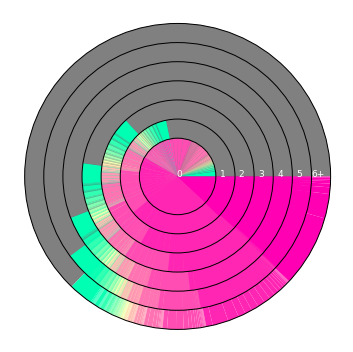

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

radius = 1.6
x = 1.4
y = 0

# Turn green to cyan and red to magenta
color_blind_accessible = True 


for i in range(6,-1,-1):
    my_ring = make_ring2(normed_rings,i,radius,50,1)
    print(f'% dead in ring {i}: {np.round(my_ring[0][1][0],2)*100}%')
    new_rgb = ['gray']
    final_rgb = ['gray']
    
    for j,v in enumerate(my_ring[0][0]):
        if j != 0:

            new_rgb.append(colorsys.hsv_to_rgb(v[0],v[1],1))   #Change v[2] to 1 for just hue and no brightness
    
    
    # If we want a color blind accessible figure, use True and use magenta and cyan
    # else use red/green
    if color_blind_accessible:
        new_new_rgb = [list(tup) for tup in new_rgb[1:]]
        for rgb in new_new_rgb:
            if any(i> 0.7 for i in rgb):
                rgb[2] = 0.7     # set blue channel
                final_rgb.append(tuple(rgb))
            else:
                rgb[2] = max(rgb)
                final_rgb.append(tuple(rgb))
    
  
        ax.pie(my_ring[0][1],colors=final_rgb,radius=radius,frame=True)
    
    else:
        ax.pie(my_ring[0][1],colors=new_rgb,radius=radius,frame=True)
        

    
    radius = radius - 0.2
    if i < 7:
        color = 'white'
    else:
        color = 'white'
        
    if i != 0:    
        if i == 6:
            ax.text(x,y,'6+',size=9,color=color)
    
            x = x - 0.16
        else:
            ax.text(x,y,str(i),size=9,color=color)
    
            x = x - 0.2
            
    else:
        ax.text(-0.01,y,str(i),size=9,color=color)

newx = 0.0
newy = 0
newradius = 0.4

for i in range(7):
    ax.add_artist(Circle((0.00,y),newradius,fill=False,color='black'))
    if i == 0:
        newx = newx + 0.2
    else:
        newx = newx + 0.16
    newradius = newradius + 0.2

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])


plt.tight_layout()

plt.savefig('Anc15_neighborhood.pdf')


# Brightness analysis

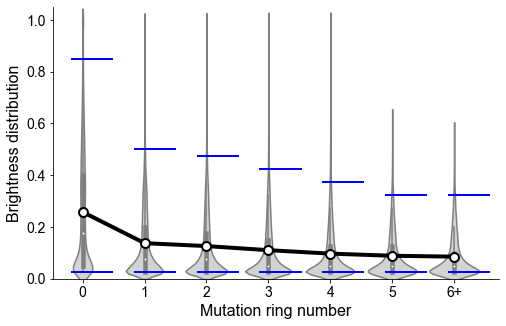

In [16]:
colors, fc, med = brightness_analysis(normed_rings,save=True,filepath='Anc15_brightness.pdf');
